In [52]:
import vnstock as vns
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from MFI import add_mfi
from RSI import add_rsi
from MACD import add_macd
from cosine import cosine
from bollinger_bands import add_bollinger_bands

In [55]:
ticker = 'VCB'

In [56]:
df = vns.stock_historical_data(symbol = ticker, start_date="2014-01-01", 
                            end_date='2024-06-01', resolution='1D', type='stock')


ConnectionError: HTTPSConnectionPool(host='services.entrade.com.vn', port=443): Max retries exceeded with url: /chart-api/v2/ohlcs/stock?from=1388509200&to=1717261200&symbol=VCB&resolution=1D (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000018E67E80FB0>: Failed to resolve 'services.entrade.com.vn' ([Errno 11001] getaddrinfo failed)"))

In [ ]:
# df = df[round(len(df)*3/4):]

In [ ]:

def calculate_indicators(data):
    add_mfi(data)
    
    data = data[['time', 'close', 'MFI']]

    # data.set_index('time', inplace = True)

    data = data.dropna()

    data['sma10'] = data['close'].rolling(window = 10, min_periods = 1).mean()
    
    data['sma50'] = data['close'].rolling(window = 50, min_periods = 1).mean()
    
    data['ema'] = data['close'].ewm(span = 10).mean()
    
    add_bollinger_bands(data)

    add_rsi(data)

    add_macd(data)

    data.dropna(inplace = True)
    
    data.reset_index(inplace = True, drop = True)

    return data


In [ ]:
df = calculate_indicators(df)
df

,time,close,MFI,sma10,sma50,ema,SMA,SD,UB,LB,RSI,EMA12,EMA26,MACD,Signal_Line
0,2014-02-07,10250,55.366261,10567.0,10369.500000,10475.139121,10369.5,294.090480,10957.680960,9781.319040,51.034483,10450.723556,10311.037739,139.685817,169.656103
1,2014-02-10,10440,58.942199,10589.0,10372.857143,10468.654307,10399.0,267.638798,10934.277596,9863.722404,56.707317,10449.073778,10320.590499,128.483279,161.421538
2,2014-02-11,10440,66.303013,10586.0,10375.909091,10463.380634,10419.5,253.200046,10925.900091,9913.099909,48.920863,10447.677812,10329.435647,118.242165,152.785663
3,2014-02-12,10690,66.662272,10578.0,10389.565217,10504.996063,10454.5,238.669007,10931.838013,9977.161987,47.014925,10484.958149,10356.144118,128.814031,147.991337
4,2014-02-13,10660,67.077220,10552.0,10400.833333,10533.408692,10476.5,236.181799,10948.863598,10004.136402,39.344262,10511.887665,10378.651961,133.235703,145.040210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,2024-05-27,90200,21.661948,91110.0,92956.000000,91015.243625,91605.0,923.081225,93451.162449,89758.837551,42.857143,91121.723651,91694.557331,-572.833681,-477.796667
2572,2024-05-28,90700,29.435584,91120.0,92850.000000,90957.926602,91590.0,935.780001,93461.560002,89718.439998,50.877193,91056.843089,91620.886418,-564.043329,-495.045999
2573,2024-05-29,89800,28.503505,91000.0,92746.000000,90747.394493,91520.0,1015.459450,93550.918900,89489.081100,40.322581,90863.482614,91486.005942,-622.523329,-520.541465
2574,2024-05-30,88600,26.309427,90600.0,92638.000000,90356.959131,91355.0,1201.523156,93758.046312,88951.953688,15.517241,90515.254519,91272.227724,-756.973205,-567.827813


In [ ]:
df_len = len(df)
train_length = 0.8
start_global = round(df_len * train_length)
df_train = df[:start_global]
df_test = df[start_global:]

In [ ]:
# df_train

In [ ]:
def RSI_signal(data, index):
    if data['RSI'].iloc[index] <= 70 and data['RSI'].iloc[index - 1] >= 70:
        return -1
    elif data['RSI'].iloc[index] >= 30 and data['RSI'].iloc[index - 1] <= 30:
        return 1
    else:
        return 0

In [ ]:
def MFI_signal(data, index):
    if data['MFI'].iloc[index] <= 80 and data['MFI'].iloc[index - 1] >= 80:
        return -1
    elif data['MFI'].iloc[index] >= 20 and data['MFI'].iloc[index - 1] <= 20:
        return 1
    else:
        return 0

In [ ]:
def MACD_signal(data, index):
    if data['MACD'].iloc[index] >= data['Signal_Line'].iloc[index] and \
        data['MACD'].iloc[index - 1] <= data['Signal_Line'].iloc[index - 1]:
        return -1
    elif data['MACD'].iloc[index] <= data['Signal_Line'].iloc[index] and \
        data['MACD'].iloc[index - 1] >= data['Signal_Line'].iloc[index - 1]:
        return 1    
    else:
        return 0

In [ ]:
def bollinger_bands_signal(data, index):
    if data['close'].iloc[index] <= data['LB'].iloc[index]:\
        #and data['close'].iloc[index - 1] >= data['LB'].iloc[index - 1]\
        return 1
    elif data['close'].iloc[index] >= data['UB'].iloc[index] and \
        data['close'].iloc[index - 1] <= data['UB'].iloc[index - 1]:
        return -1
    else:
        return 0

In [ ]:
def pattern_matching(start, window, indicator):
    df_temp = df_test[indicator].iloc[start-window + 1:start + 1]
    df_window = df_train[indicator].copy()  
    df_window -= df_window.iloc[0]
    cosines = []
    for i in range(len(df_window)-window):
        df_compare = df_window.iloc[i:i+window].copy()
        df_compare -= df_compare.iloc[0]
        cosines.append(cosine(df_temp, df_compare, window))
    return cosines.index(max(cosines))

In [ ]:
def matching_signal(data, start):
    pattern_start = pattern_matching(start, window, indicator)
    predicted_earnings = data[indicator].iloc[pattern_start + window*2 - 1] - data[indicator].iloc[pattern_start + window - 1]
    
    if predicted_earnings > 0:
        return 0.25
    else:
        return -0.25

In [ ]:
signal_dict = {'MFI': MFI_signal, 'MACD': MACD_signal, 'bollinger_bands': bollinger_bands_signal, 'RSI': RSI_signal, 'matching': matching_signal}

def calculate_signal(data, index, signal_list):
    temp = 0
    for signal in signal_list:
        temp += signal_dict[signal](data, index)
    return temp

In [ ]:
# For testing parameters

profit_and_loss = []

for i in range(1,41):
    for j in range(1,31):
        indicator = 'close'
        start = 50  # Is the current day, must be equal to or higher than window
        window = 50 # Looks into the past
        df_matching = df_train.copy()
        budget = 10000000  # How much money to start with, doesnt really matter
        total_assets = [10000000]
        stocks_holding = 0
        buy_points = []
        sell_points = []
        signal = 0
        signal_list = ['MFI', 'MACD', 'bollinger_bands', 'RSI']

        upper_signal = i/10
        lower_signal = -i/10
        decay = j/10
        
        for k in range(len(df_matching) - window):
            current_price = df_matching['close'].iloc[start]
            signal = signal + calculate_signal(df_matching, start, signal_list)
            if signal >= upper_signal:
                stocks_to_buy = (budget // 2) // current_price  #Spends half the budget to buy
                
                if stocks_to_buy > 0:
                    budget -= stocks_to_buy * current_price
                    stocks_holding += stocks_to_buy
                    buy_points.append(start)
                    
            elif (signal <= lower_signal) and (stocks_holding > 0):
                sell_points.append(start)
                stocks_sold = stocks_holding
                budget += stocks_sold * current_price
                stocks_holding -= stocks_sold 

            total_assets.append(budget + stocks_holding*current_price)
            start += 1
            
            if signal >= 0:
                signal = max(0, signal - decay)
            else:
                signal = min(0, signal + decay)
            # Decaying the signal
            
        current_price = df_matching['close'].iloc[-1]
        total_assets.append(budget + stocks_holding * current_price)

        profit_and_loss.append([((total_assets[-1] - total_assets[0])/total_assets[0]) * 100, i/10, j/10])

In [ ]:
train_results = sorted(profit_and_loss, key= lambda x: x[0], reverse = True)
train_results

[[474.33889999999997, 1.8, 0.3],
 [433.2182, 1.9, 0.3],
 [398.84810000000004, 3.0, 0.2],
 [391.7958, 2.9, 0.2],
 [371.1328, 2.0, 0.3],
 [361.4325, 1.8, 0.4],
 [360.44390000000004, 2.1, 0.3],
 [353.611, 2.3, 0.3],
 [346.8625, 2.4, 0.3],
 [338.1162, 2.2, 0.3],
 [328.6981, 1.7, 0.4],
 [315.2313, 2.8, 0.3],
 [314.2375, 1.9, 0.4],
 [314.2375, 2.0, 0.4],
 [310.9058, 2.7, 0.3],
 [287.9441, 2.2, 0.4],
 [281.4182, 2.8, 0.2],
 [279.6554, 2.7, 0.2],
 [269.5979, 2.1, 0.4],
 [253.1795, 3.2, 0.2],
 [253.1795, 3.3, 0.2],
 [250.1369, 3.6, 0.3],
 [249.8964, 3.7, 0.3],
 [248.98579999999998, 3.3, 0.1],
 [248.6523, 3.5, 0.2],
 [247.3267, 3.8, 0.3],
 [242.8391, 3.4, 0.2],
 [239.9699, 3.1, 0.2],
 [239.1989, 3.9, 0.3],
 [239.1989, 4.0, 0.3],
 [239.19160000000002, 3.1, 0.4],
 [239.19160000000002, 3.2, 0.4],
 [225.89339999999999, 3.6, 0.1],
 [225.134, 3.5, 0.1],
 [223.5562, 3.2, 0.1],
 [221.3237, 3.4, 0.1],
 [220.9151, 3.3, 0.4],
 [220.9151, 3.4, 0.4],
 [220.46480000000003, 2.2, 0.2],
 [219.82659999999998, 2.6

In [ ]:
len(total_assets)

2013

In [ ]:
limit = train_results[0][1]
trained_decay = train_results[0][2]

In [ ]:
# limit = np.mean([train_results[i][1] for i in range(len(train_results))][:5])
# trained_decay = np.mean([train_results[i][2] for i in range(len(train_results))][:5])

In [ ]:
start = 50  # At which point to start investing
df_matching = df_test.copy()
budget = 1000000  # How much money to start with, doesnt really matter
total_assets = [1000000]
window = 50
stocks_holding = 0
buy_points = []
sell_points = []
signal = 0
signal_list = ['MFI', 'MACD', 'bollinger_bands']
upper_signal = limit
lower_signal = -limit
decay = trained_decay
for k in range(len(df_matching) - window):
   current_price = df_matching['close'].iloc[start]
   signal = signal + calculate_signal(df_matching, start, signal_list)
   if signal >= upper_signal:
      stocks_to_buy = (budget // 2) // current_price  #Spends half the budget to buy
      
      if stocks_to_buy > 0:
         budget -= stocks_to_buy * current_price
         stocks_holding += stocks_to_buy
         buy_points.append(start)
         
   elif (signal <= lower_signal) and (stocks_holding > 0):
      
      sell_points.append(start)
      stocks_sold = stocks_holding
      budget += stocks_sold * current_price
      stocks_holding -= stocks_sold

   total_assets.append(budget + stocks_holding*current_price)
   start += 1

   if signal >= 0:
      signal = max(0, signal - decay)
   else:
      signal = min(0, signal + decay)
   # Decaying the signal

   

current_price = df_matching['close'].iloc[-1]
total_assets.append(budget + stocks_holding * current_price)

In [ ]:
print(f'Profit/loss is: {(total_assets[-1] - total_assets[0])/(total_assets[0]) * 100}%')

Profit/loss is: 52.153000000000006%


In [ ]:
print(f'Stock grew by: {(df_test['close'].iloc[-1] - df_test['close'].iloc[0])/df_test['close'].iloc[0] * 100}%')
print(f'From {df_test['time'].iloc[0]} to {df_test['time'].iloc[-1]}')

Stock grew by: 33.74233128834356%
From 2022-05-12 to 2024-05-31


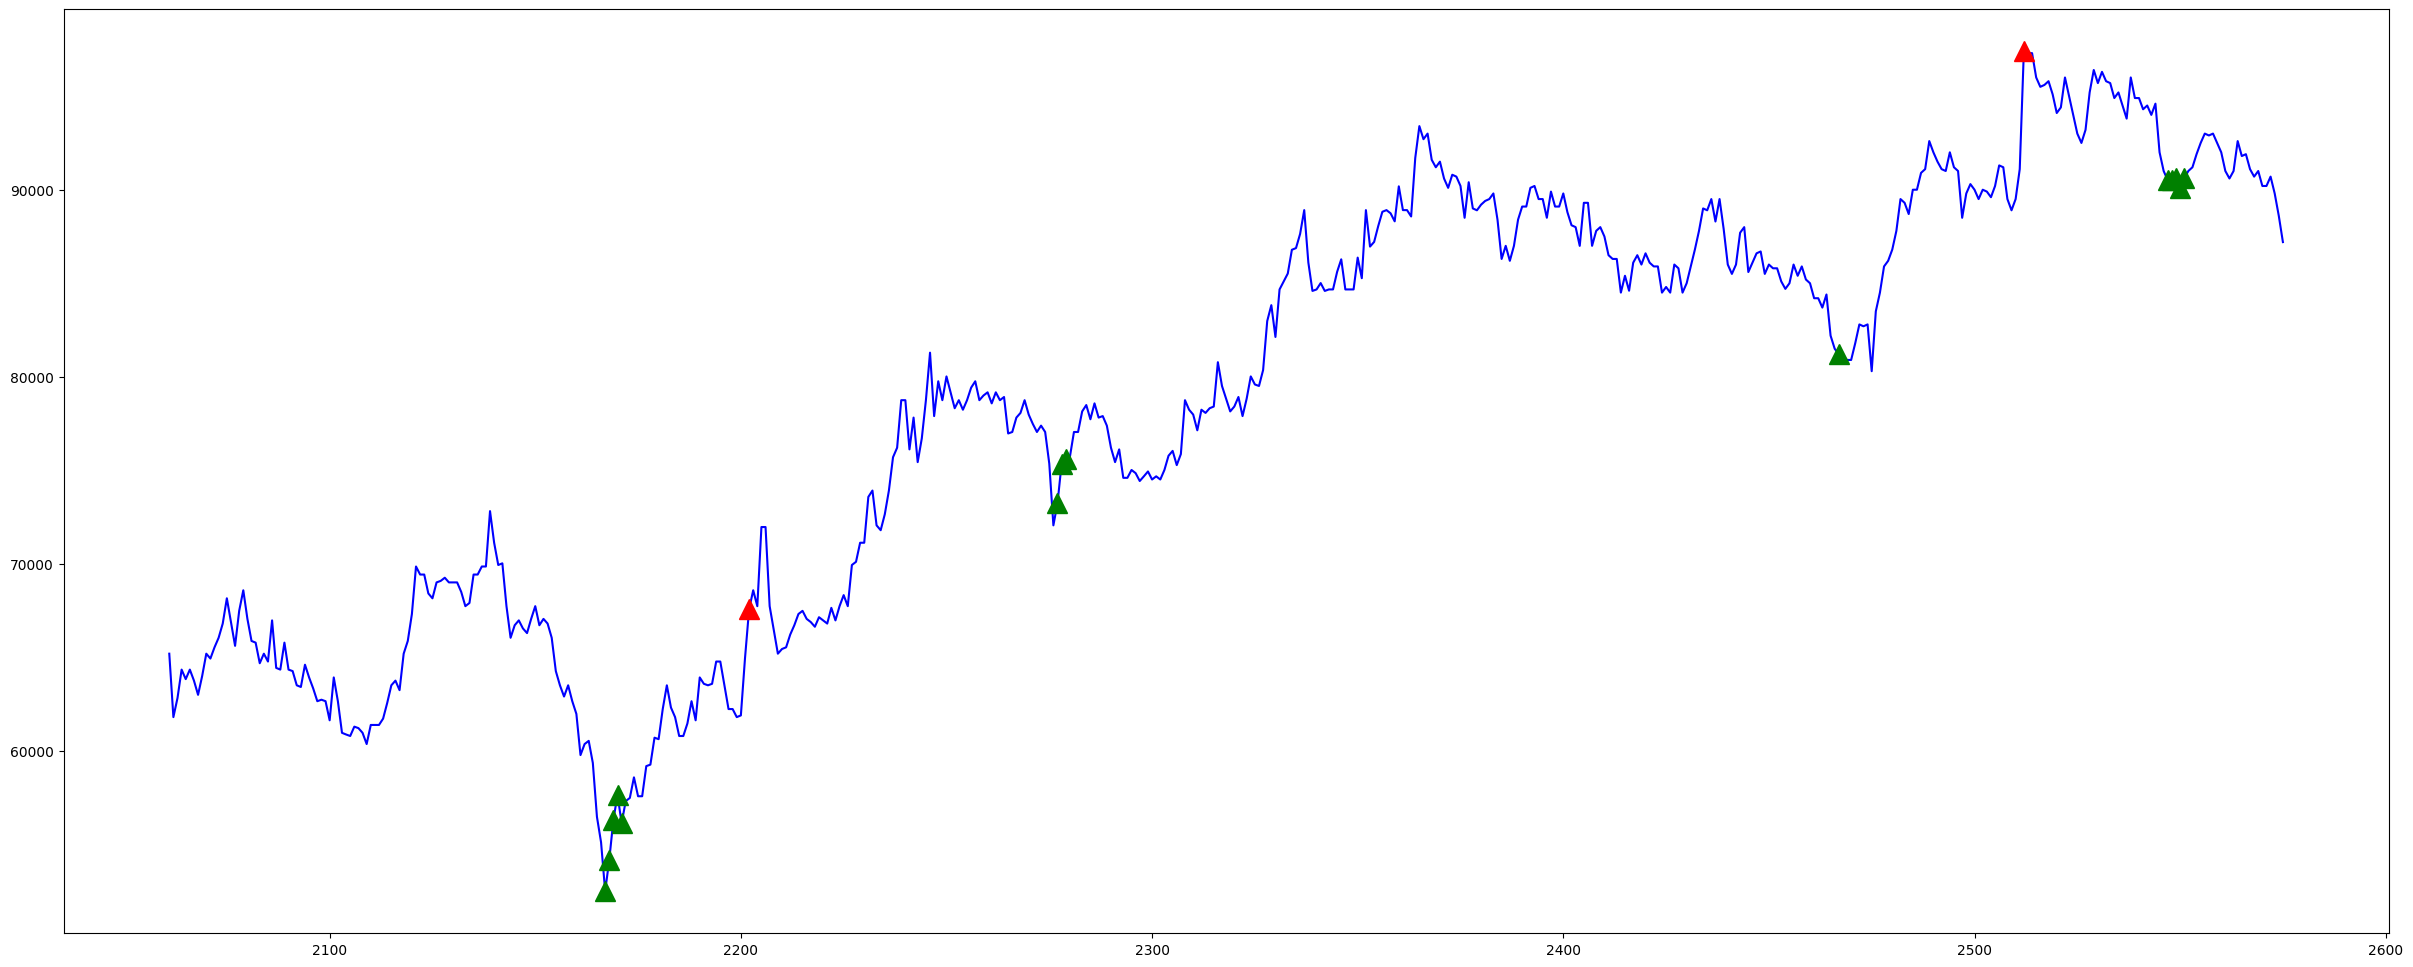

In [ ]:
start = 0
plt.subplots(figsize =(30,12))
plt.plot(df_test['close'], label = "data", color = "b")
plt.plot(df_test.iloc[buy_points].index, df_test['close'].iloc[buy_points],
'^', ms=15, label='Buy Signal', color='green')
plt.plot(df_test.iloc[sell_points].index, df_test['close'].iloc[sell_points],
'^', ms=15, label='Buy Signal', color='red')

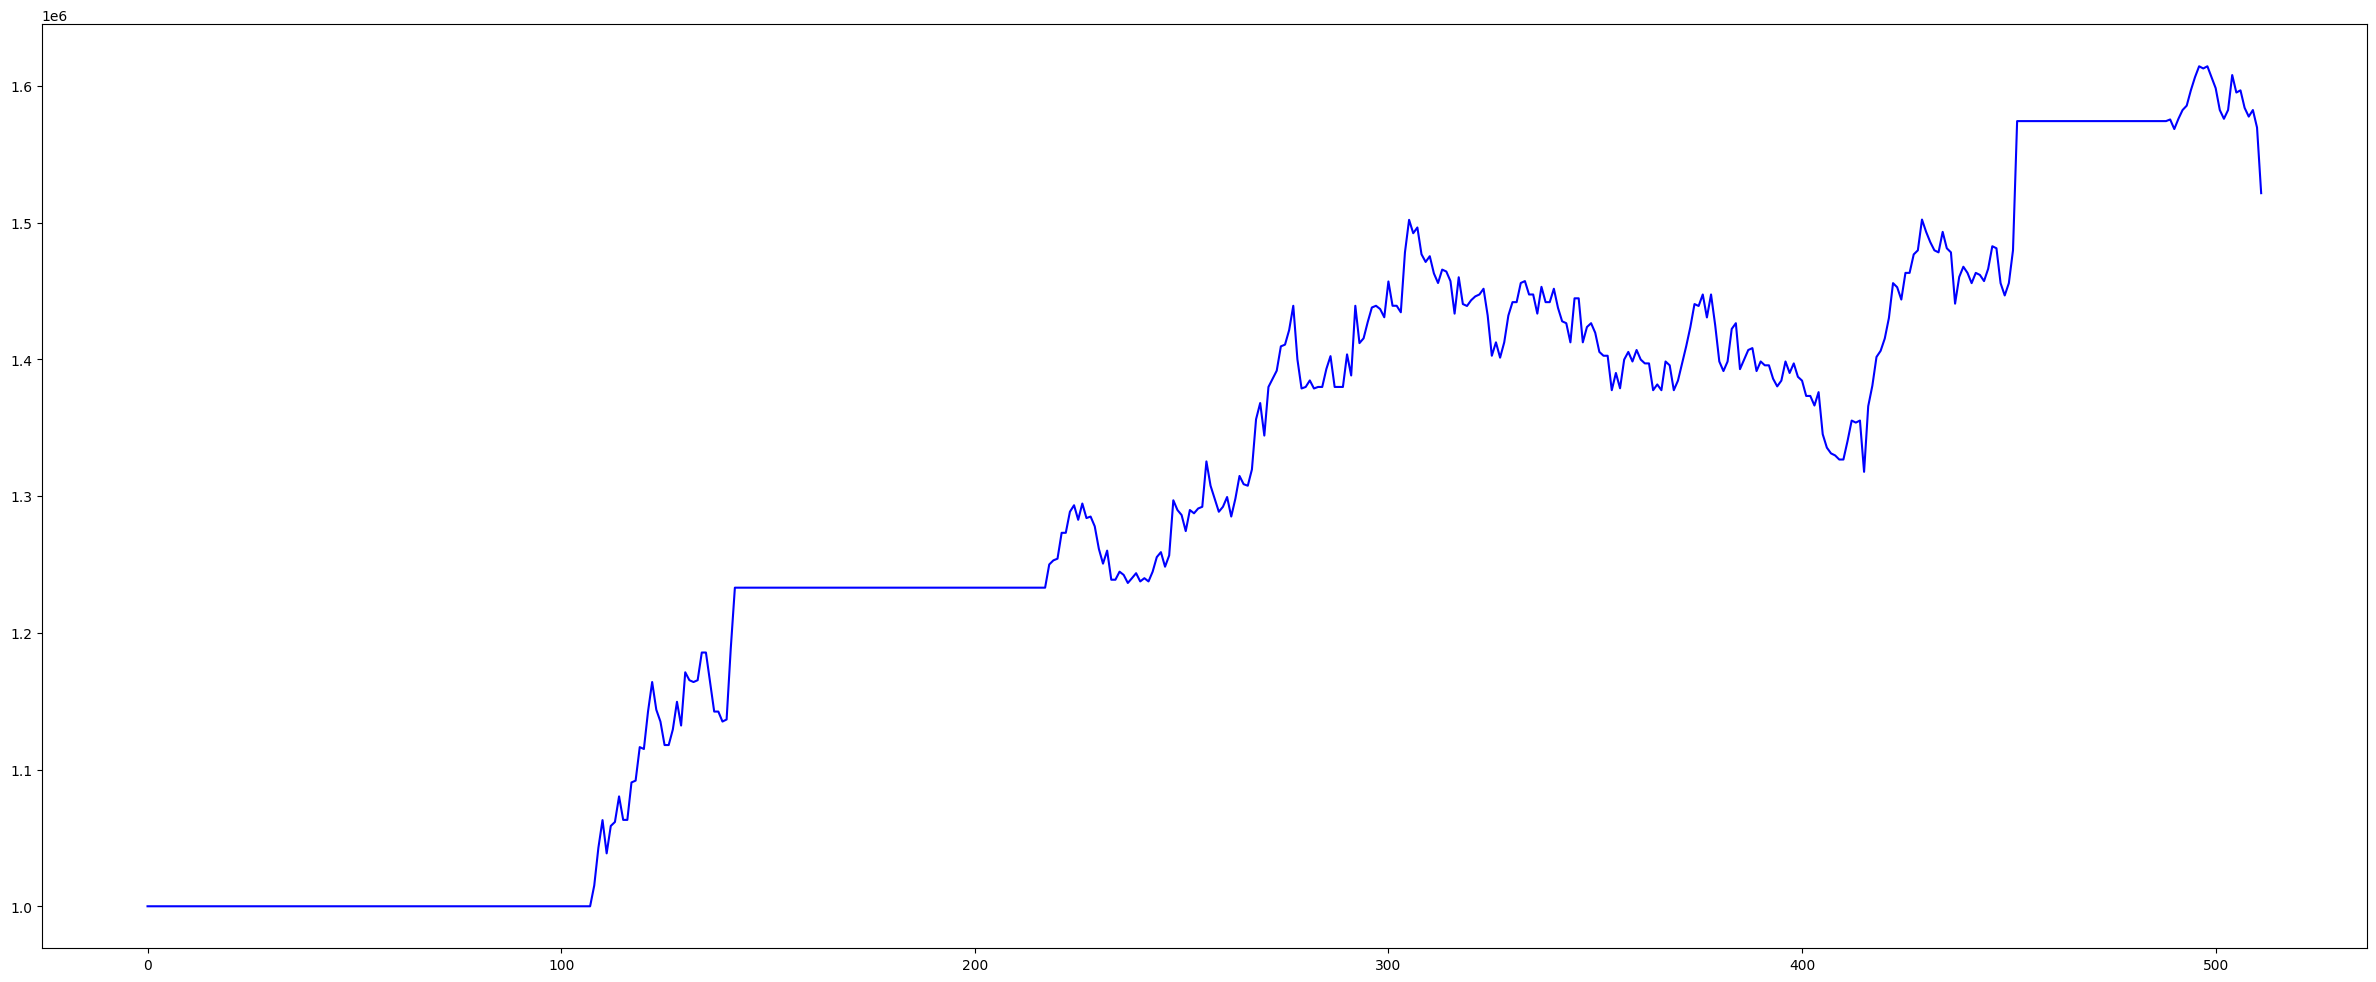

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(total_assets, label = "data", color = "b")